In [1]:
print('hello')

hello


# Install Libary

In [1]:
!pip install torch torchvision torchaudio

In [2]:
!pip install pandas

In [3]:
!pip install pillow

In [4]:
!pip install numpy

In [5]:
!pip install scikit-learn

In [6]:
!pip install matplotlib

In [7]:
!pip install seaborn

In [8]:
!pip install pycocotools

In [9]:
!pip install tqdm

In [49]:
!pip install torchview

In [50]:
!pip install torch-summary

In [12]:
!pip freeze requirements.txt

asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1733218098505/work
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1733502965406/work
contourpy==1.3.1
cycler==0.12.1
debugpy @ file:///D:/bld/debugpy_1741148420317/work
decorator @ file:///home/conda/feedstock_root/build_artifacts/decorator_1740384970518/work
exceptiongroup @ file:///home/conda/feedstock_root/build_artifacts/exceptiongroup_1733208806608/work
executing @ file:///home/conda/feedstock_root/build_artifacts/executing_1733569351617/work
filelock==3.17.0
fonttools==4.56.0
fsspec==2025.3.0
importlib_metadata @ file:///home/conda/feedstock_root/build_artifacts/importlib-metadata_1737420181517/work
ipykernel @ file:///D:/bld/ipykernel_1719845595208/work
ipython @ file:///D:/bld/bld/rattler-build_ipython_1741457145/work
ipython_pygments_lexers @ file:///home/conda/feedstock_root/build_artifacts/ipython_pygm

In [2]:
!pip install -r requirements.txt

In [52]:
!pip install graphviz

# Setup Lib

In [53]:
# model
import torch
from torch import nn
import torchvision.models as models
import torch.optim as optim
from torchview import draw_graph
from torchsummary import summary

# load dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

# transform
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

# other
import os
import all_models
import random
from tqdm import tqdm

# data and data preparation
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import json

# plot data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

#eval
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# set random
torch.manual_seed(0)


# Check devcice and worker

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cpu device
num_workers = 12 cores


# Workshop II 01 early stopping

## mapping csv

In [9]:
def mapping_csv(path:str):
  #Create empty lists
  filename = []
  label = []

  #read all file from subfolders
  for dirname, _, filenames in os.walk(f'{path}'):
    for file in filenames:
      f = os.path.join(dirname, file)
      if '.png' in f:
        filename.append(f)
        # print(dirname.split('\\'))
        label.append(dirname.split('\\')[6])


  #Create a dataframe
  df = pd.DataFrame({'filename':filename, 'label':label})
  return df

In [10]:
df_test = mapping_csv(r'D:\Lecture & Lab\Workshop_II\Final_Folder\Small_Data_CoV2\Small_Data_CoV2_test')
df_train = mapping_csv(r'D:\Lecture & Lab\Workshop_II\Final_Folder\Small_Data_CoV2\Small_Data_CoV2_train')
df_val = mapping_csv(r'D:\Lecture & Lab\Workshop_II\Final_Folder\Small_Data_CoV2\Small_Data_CoV2_val')

In [11]:
df_test.head(5)

,filename,label
0,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,Covid
1,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,Covid
2,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,Covid
3,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,Covid
4,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,Covid


## label transform

In [12]:
def label_transform(df):
  le = LabelEncoder()
  df['label'] = le.fit_transform(df['label'])
  return df

In [13]:
transformed_test = label_transform(df_test)
transformed_train = label_transform(df_train)
transformed_val = label_transform(df_val)

In [14]:
transformed_test

,filename,label
0,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,0
1,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,0
2,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,0
3,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,0
4,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,0
...,...,...
270,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,2
271,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,2
272,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,2
273,D:\Lecture & Lab\Workshop_II\Final_Folder\Smal...,2


## RGB_CustomImageDataset

In [15]:
class RGB_CustomImageDataset(Dataset):
  def __init__(self, im_filename, y, transform=None):
    self.im_filename = im_filename
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    img_path = self.im_filename.iloc[idx] # Changed this line to access the Series correctly
    image = Image.open(img_path).convert('L')
    label = self.y.iloc[idx] # Changed this line to access the Series correctly

    if self.transform:
       image = self.transform(image)

    image_np = np.array(image)

    return image_np, label

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [17]:
test_data = RGB_CustomImageDataset(df_test['filename'], df_test['label'], transform= transform)
train_data = RGB_CustomImageDataset(df_train['filename'], df_train['label'],  transform= transform)
val_data = RGB_CustomImageDataset(df_val['filename'], df_val['label'], transform= transform)

In [18]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# num_workers=os.cpu_count()
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

C:\Users\surap\AppData\Local\Temp\ipykernel_44344\2923507177.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(image)


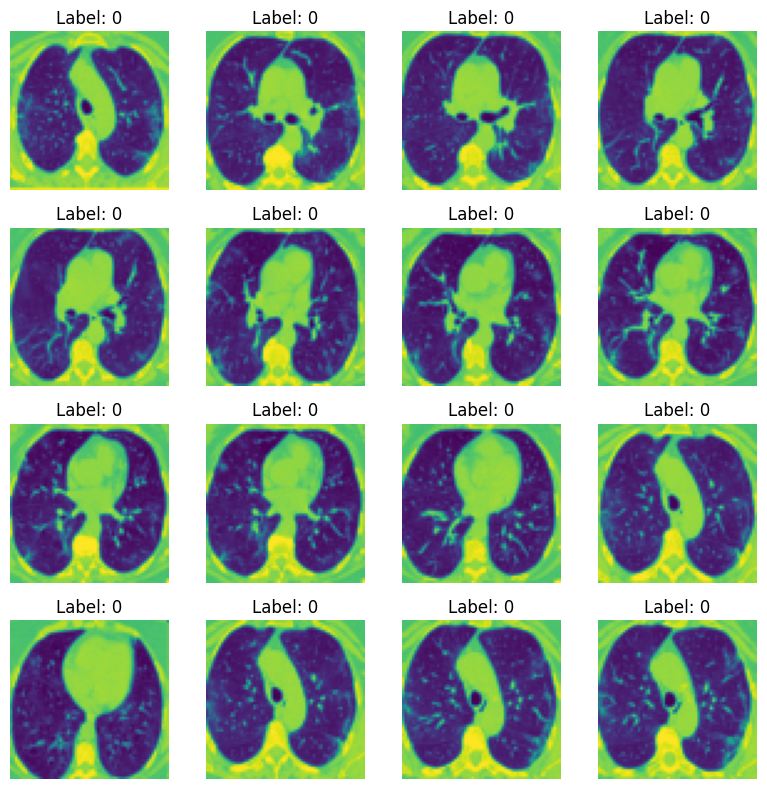

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = train_data.__getitem__(i)
    axes[row, col].imshow(im.transpose(1, 2, 0))  # Use transpose for NumPy arrays
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Transfer Learning

In [20]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
num_classes = 3  # Get the number of classes from your dataset
in_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(in_features, num_classes)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
model = vgg16
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Classification Model

In [21]:
def conv_output_size(input_width, input_height, kernel_size, stride, padding):
    """
    Calculate the output width and height of a convolutional layer.
    
    Parameters:
    - input_width: Width of the input (W_in)
    - input_height: Height of the input (H_in)
    - kernel_size: Size of the convolutional kernel (K_h, K_w)
    - stride: Stride of the convolution (S)
    - padding: Padding applied (P)
    
    Returns:
    - output_width: Width of the output (W_out)
    - output_height: Height of the output (H_out)
    """
    # Calculate output height and width using the formula
    output_height = (input_height - kernel_size + 2 * padding) // stride + 1
    output_width = (input_width - kernel_size + 2 * padding) // stride + 1
    
    return output_width, output_height

# Example usage:
input_width = 64
input_height = 64
kernel_size = 3
stride = 2
padding = 1

output_width, output_height = conv_output_size(input_width, input_height, kernel_size, stride, padding)

print(f"Output size: {output_width} x {output_height}")

Output size: 32 x 32


In [22]:
batch_size = 1
input_tensor = torch.randn(batch_size, 1, 64, 64)
conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) #original stride2
conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) #stride2
fc1 = nn.Linear(64*16*16, 128)
fc2 = nn.Linear(128, 3)
x = conv1(input_tensor)
print(x.shape)
x = conv2(x)
print(x.shape)
x = nn.Flatten()(x) # 64*16*16
print(x.shape)
x = fc1(x)
print(x.shape)
x = fc2(x)
print(x.shape)

torch.Size([1, 32, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 16384])
torch.Size([1, 128])
torch.Size([1, 3])


In [28]:
class SimpleObjectClassification(nn.Module):
      def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1) #original stride2
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) #stride2
            self.fc1 = nn.Linear(64*16*16, 128)
            self.fc2 = nn.Linear(128, 3)

      def forward(self, x):
            x = torch.relu(self.conv1(x))
            x = torch.relu(self.conv2(x))
            x = nn.Flatten()(x)
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            return x

In [29]:
model = SimpleObjectClassification()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

SimpleObjectClassification(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

## Training

### Early Stopping

In [38]:
def train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weight=None
    for ep in range(epochs):
        print(f"Epoch {ep+1}\n-------------------------------")
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        val_loss = test_loss(val_loader, model, loss_fn)
        print(f"Epoch {ep+1} Train loss: {train_loss:>7f}  Val loss: {val_loss:>7f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_weight=model.state_dict().copy()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print('Early stopping!')
            break
    print("Done!")
    model.load_state_dict(best_weight)
    return model

def test_loss(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss=0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        test_loss += loss.item()
    test_loss /= num_batches
    return test_loss

def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss=0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    train_loss /= batch
    return train_loss

### Basic

In [30]:
# Training loop
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
learning_rate = 1e-3
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# training_loop(model, train_loader, criterion=loss_fn, optimizer=optimizer, num_epochs=epochs)
train_loop(train_loader,val_loader, model, loss_fn, optimizer, epochs=epochs, patience=5)

Epoch 1
-------------------------------


C:\Users\surap\AppData\Local\Temp\ipykernel_44344\2923507177.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(image)


Epoch 1 Train loss: 1.090626  Val loss: 1.074387
Epoch 2
-------------------------------
Epoch 2 Train loss: 1.089704  Val loss: 1.075078
Epoch 3
-------------------------------
Epoch 3 Train loss: 1.087492  Val loss: 1.076021
Epoch 4
-------------------------------
Epoch 4 Train loss: 1.087725  Val loss: 1.076554
Epoch 5
-------------------------------
Epoch 5 Train loss: 1.085318  Val loss: 1.077116
Epoch 6
-------------------------------
Epoch 6 Train loss: 1.084587  Val loss: 1.077918
Early stopping!
Done!


SimpleObjectClassification(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [40]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    predicted_labels = []
    true_labels = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            predicted_labels.extend(pred.argmax(1).cpu().numpy())
            true_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return predicted_labels, true_labels

In [41]:
loss_fn = nn.CrossEntropyLoss()

test_loop(test_loader, model, loss_fn)

C:\Users\surap\AppData\Local\Temp\ipykernel_44344\2923507177.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(image)


Test Error: 
 Accuracy: 41.5%, Avg loss: 1.096256 



([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64

C:\Users\surap\AppData\Local\Temp\ipykernel_44344\2923507177.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image_np = np.array(image)


Test Error: 
 Accuracy: 41.5%, Avg loss: 1.096256 

              precision    recall  f1-score   support

           0       0.41      1.00      0.59       114
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        94

    accuracy                           0.41       275
   macro avg       0.14      0.33      0.20       275
weighted avg       0.17      0.41      0.24       275



d:\Programs\Anaconda\envs\workshop_ai_lab_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Anaconda\envs\workshop_ai_lab_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Anaconda\envs\workshop_ai_lab_final\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

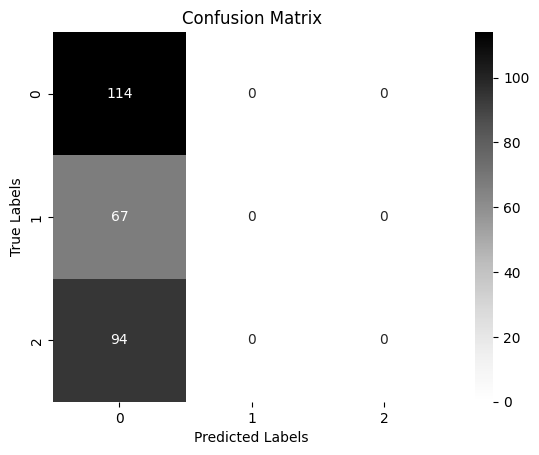

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predicted, true = test_loop(test_loader, model, loss_fn)

cm = confusion_matrix(true, predicted)

print(classification_report(true, predicted))


import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Grays')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
model = SimpleObjectClassification()
model = model.to(device)
summary(model, (1, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          320
├─Conv2d: 1-2                            [-1, 64, 16, 16]          18,496
├─Linear: 1-3                            [-1, 128]                 2,097,280
├─Linear: 1-4                            [-1, 3]                   387
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
Total mult-adds (M): 7.11
Input size (MB): 0.02
Forward/backward pass size (MB): 0.38
Params size (MB): 8.07
Estimated Total Size (MB): 8.47


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          320
├─Conv2d: 1-2                            [-1, 64, 16, 16]          18,496
├─Linear: 1-3                            [-1, 128]                 2,097,280
├─Linear: 1-4                            [-1, 3]                   387
Total params: 2,116,483
Trainable params: 2,116,483
Non-trainable params: 0
Total mult-adds (M): 7.11
Input size (MB): 0.02
Forward/backward pass size (MB): 0.38
Params size (MB): 8.07
Estimated Total Size (MB): 8.47

In [59]:
# draw_graph(model,directory='D:\Lecture & Lab\Workshop_II\Final_Folder', input_size=(1, 1, 64, 64)).visual_graph

# Workshop II 02 Object Detection with PyTorch

In [43]:
class SyntheticDectectionDataset(Dataset):
  def __init__(self, images_path, annotations_file, transform=None):
    self.coco = COCO(annotations_file)
    self.images_path = images_path
    self.image_ids = list(self.coco.imgs.keys())
    self.transform = transform

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_info = self.coco.imgs[image_id]
    image_path = os.path.join(self.images_path, image_info['file_name']).replace("\\", "/")

    image = Image.open(image_path).convert('L')
    image = np.array(image, dtype=np.float32) / 255.0

    anns_ids = self.coco.getAnnIds(imgIds=image_id)
    anns = self.coco.loadAnns(anns_ids)

    bboxes = [ann['bbox'] for ann in anns]
    labels = [ann['category_id'] for ann in anns]

    bboxes = np.array(bboxes, dtype=np.float32)
    bboxes[:, 0] /= image_info['width']
    bboxes[:, 1] /= image_info['height']
    bboxes[:, 2] /= image_info['width']
    bboxes[:, 3] /= image_info['height']

    bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {'bboxes': bboxes,
              'labels': labels,}

    if self.transform:
      image = self.transform(image)

    return image, target

In [46]:
train_dir = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\train"
test_dir = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\test"
val_dir = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\val"

train_anns = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\train.json"
test_anns = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\test.json"
val_anns = r"D:\Lecture & Lab\Workshop_II\Final_Folder\dataset_simpleDetection\val.json"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [47]:
# Create datasets
train_dataset = SyntheticDectectionDataset(train_dir, train_anns, transform)
test_dataset = SyntheticDectectionDataset(test_dir, test_anns, transform)
val_dataset = SyntheticDectectionDataset(val_dir, val_anns, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [63]:
# Create a CNN model for object detection

class SimpleObjectDetector(nn.Module):
  def __init__(self):
        super(SimpleObjectDetector, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 64, 128)
        self.fc2 = nn.Linear(128, 5) # class, x, y, w, h

  def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = nn.Flatten()(x)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

In [60]:
dataloaders = {'train': train_loader, 'val': val_loader}

In [61]:
# Create train function with collect loss history

def train_model(model, dataloaders, criterion, optimizer, num_epochs, weights_name='weight_save.pth'):

    model = model.to(device)
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            data_loader = dataloaders[phase]

            with tqdm(total=len(data_loader), desc=f"{phase.capitalize()} Epoch {epoch + 1}") as pbar:
                for images, targets in data_loader:
                    images = images.to(device)
                    targets = {k: v.to(device) for k, v in targets.items()}

                    target_bboxes = targets['bboxes'].view(-1, 4)  # (N, 4)
                    target_classes = targets['labels'].view(-1, 1)  # (N, 1)
                    target_combined = torch.cat([target_classes, target_bboxes], dim=1)  # (N, 5)

                    if phase == 'train':
                        optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        loss = criterion(outputs, target_combined)

                        # Backward
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * images.size(0)
                    pbar.update(1)

            epoch_loss = running_loss / len(data_loader.dataset)
            history[f"{phase}_loss"].append(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), weights_name)
                best_model = model
                print(f"Saved Best Model Weights: {weights_name}")

    return best_model, history

In [62]:
# Create test function for predict test_loader
def test_model(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            target_bboxes = targets['bboxes'].view(-1, 4)
            target_classes = targets['labels'].view(-1, 1)
            target_combined = torch.cat([target_classes, target_bboxes], dim=1)

            outputs = model(images)

            predictions.append(outputs.cpu().numpy())
            ground_truths.append(target_combined.cpu().numpy())

    predictions = np.concatenate(predictions)
    ground_truths = np.concatenate(ground_truths)
    return predictions, ground_truths

In [64]:
# Set dataloader
dataloaders = {'train': train_loader, 'val': val_loader}

# Training setting
model = SimpleObjectDetector()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8)
epochs = 10

In [65]:
# Training Model
best_model, train_history = train_model(model, dataloaders, criterion, optimizer, epochs, 'SimpleObjectDetector.pth')

Epoch 1/10
------------------------------


Train Epoch 1: 100%|██████████| 18/18 [00:01<00:00, 13.33it/s]


Train Loss: 0.0725


Val Epoch 1: 100%|██████████| 4/4 [00:00<00:00, 22.66it/s]


Val Loss: 0.0673
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 2/10
------------------------------


Train Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 31.21it/s]


Train Loss: 0.0595


Val Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 121.48it/s]


Val Loss: 0.0604
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 3/10
------------------------------


Train Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 32.79it/s]


Train Loss: 0.0527


Val Epoch 3: 100%|██████████| 4/4 [00:00<00:00, 130.37it/s]


Val Loss: 0.0533
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 4/10
------------------------------


Train Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 28.70it/s]


Train Loss: 0.0461


Val Epoch 4: 100%|██████████| 4/4 [00:00<00:00, 147.94it/s]


Val Loss: 0.0477
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 5/10
------------------------------


Train Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 33.31it/s]


Train Loss: 0.0421


Val Epoch 5: 100%|██████████| 4/4 [00:00<00:00, 137.46it/s]


Val Loss: 0.0433
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 6/10
------------------------------


Train Epoch 6: 100%|██████████| 18/18 [00:00<00:00, 30.97it/s]


Train Loss: 0.0381


Val Epoch 6: 100%|██████████| 4/4 [00:00<00:00, 91.30it/s]


Val Loss: 0.0366
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 7/10
------------------------------


Train Epoch 7: 100%|██████████| 18/18 [00:00<00:00, 25.87it/s]


Train Loss: 0.0341


Val Epoch 7: 100%|██████████| 4/4 [00:00<00:00, 123.12it/s]


Val Loss: 0.0331
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 8/10
------------------------------


Train Epoch 8: 100%|██████████| 18/18 [00:00<00:00, 28.72it/s]


Train Loss: 0.0319


Val Epoch 8: 100%|██████████| 4/4 [00:00<00:00, 133.76it/s]


Val Loss: 0.0296
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 9/10
------------------------------


Train Epoch 9: 100%|██████████| 18/18 [00:00<00:00, 33.06it/s]


Train Loss: 0.0298


Val Epoch 9: 100%|██████████| 4/4 [00:00<00:00, 134.72it/s]


Val Loss: 0.0278
Saved Best Model Weights: SimpleObjectDetector.pth
Epoch 10/10
------------------------------


Train Epoch 10: 100%|██████████| 18/18 [00:00<00:00, 28.88it/s]


Train Loss: 0.0274


Val Epoch 10: 100%|██████████| 4/4 [00:00<00:00, 116.47it/s]

Val Loss: 0.0275
Saved Best Model Weights: SimpleObjectDetector.pth


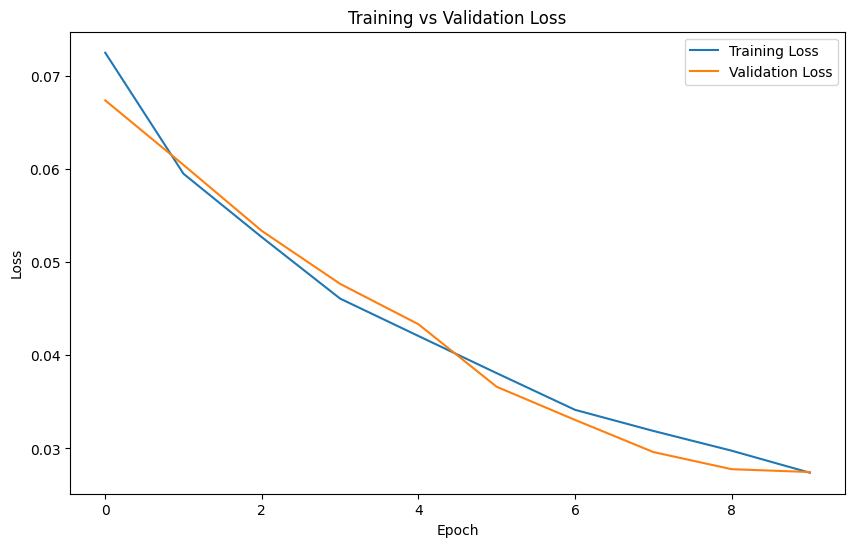

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(train_history['train_loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.legend()
plt.show()

In [68]:
# IoU function to compute intersection over union
def compute_iou(pred_bbox, gt_bbox):
    # Calculate intersection coordinates
    x1 = max(pred_bbox[0], gt_bbox[0])
    y1 = max(pred_bbox[1], gt_bbox[1])
    x2 = min(pred_bbox[0] + pred_bbox[2], gt_bbox[0] + gt_bbox[2])
    y2 = min(pred_bbox[1] + pred_bbox[3], gt_bbox[1] + gt_bbox[3])

    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    pred_area = pred_bbox[2] * pred_bbox[3]
    gt_area = gt_bbox[2] * gt_bbox[3]
    union_area = pred_area + gt_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0.0
    return iou


def calculate_performance(predictions, ground_truths, iou_threshold=0.5):
    TP = 0
    FP = 0
    FN = 0
    iou_values = []

    for pred, gt in zip(predictions, ground_truths):
        iou = compute_iou(pred[1:], gt[1:])
        iou_values.append(iou)

        if iou >= iou_threshold and np.argmax(pred[:1]) == np.argmax(gt[:1]):
            TP +=1
        elif iou < iou_threshold and np.argmax(pred[:1]) == np.argmax(gt[:1]):
            FN +=1
        elif iou >= iou_threshold and np.argmax(pred[:1]) != np.argmax(gt[:1]):
            FP += 1

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    mean_iou = np.mean(iou_values)

    return precision, recall, f1_score, mean_iou

In [69]:
predictions, ground_truths = test_model(model, test_loader)

precision, recall, f1_score, mean_iou = calculate_performance(predictions, ground_truths)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

Precision: 1.0000
Recall: 0.7333
F1-Score: 0.8462
Mean IoU: 0.5541


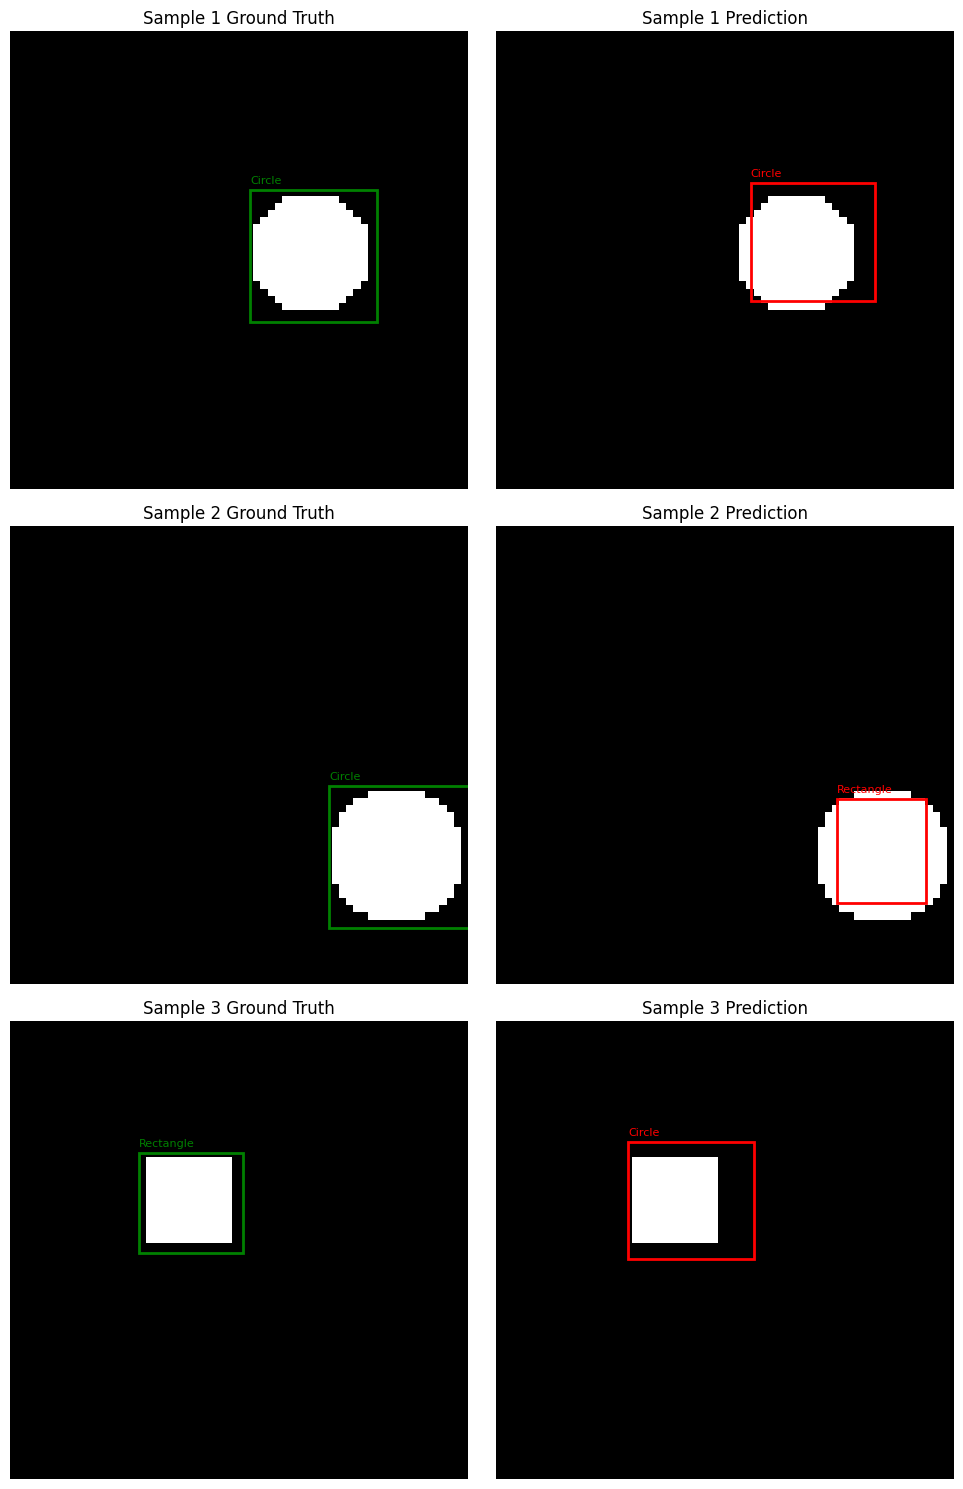

In [70]:
def visualize_predictions(model, test_loader, num_samples=3):
    model.eval()
    images_so_far = 0
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}
            outputs = model(images)

            for i in range(images.size(0)):
                if images_so_far >= num_samples:
                    break

                image = images[i].cpu().numpy().squeeze()
                gt_bboxes = targets['bboxes'][i].cpu().numpy()
                gt_labels = targets['labels'][i].cpu().numpy()
                pred_bbox = outputs[i, 1:].cpu().detach().numpy()
                pred_class = outputs[i, 0].cpu().detach().numpy()

                # Denormalize bounding boxes
                gt_bboxes = gt_bboxes * 64
                pred_bbox = pred_bbox * 64

                ax_gt = axes[images_so_far, 0]
                ax_pred = axes[images_so_far, 1]

                # Plot ground truth
                ax_gt.imshow(image, cmap='gray')
                ax_gt.set_title(f"Sample {images_so_far + 1} Ground Truth")
                for bbox, label in zip(gt_bboxes, gt_labels):
                    x, y, w, h = bbox
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
                    ax_gt.add_patch(rect)
                    label_text = "Circle" if label == 0 else "Rectangle"
                    ax_gt.text(x, y - 1, label_text, color='g', fontsize=8)
                ax_gt.axis('off')

                # Plot predictions
                ax_pred.imshow(image, cmap='gray')
                ax_pred.set_title(f"Sample {images_so_far + 1} Prediction")
                x, y, w, h = pred_bbox
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                ax_pred.add_patch(rect)
                label_text = "Circle" if pred_class < 0.5 else "Rectangle"
                ax_pred.text(x, y - 1, label_text, color='r', fontsize=8)
                ax_pred.axis('off')

                images_so_far += 1

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

# Workshop II 3 Segmentation

In [71]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

d:\Programs\Anaconda\envs\workshop_ai_lab_final\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


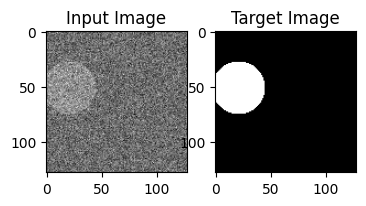

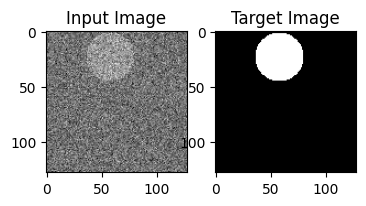

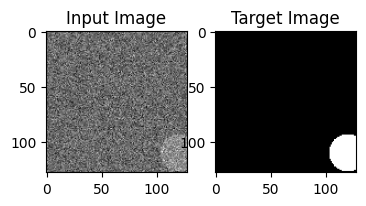

In [72]:
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


In [ ]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        y = self.conv(x)
        # Upsample
        x = self.conv_transpose(y)
        x=torch.sigmoid(x)
        return x, y